In [ ]:
# pip install dea_tools

In [41]:
import datacube
import odc.geo.xr
from odc.algo import mask_cleanup
from dea_tools.spatial import xr_rasterize
import matplotlib.pyplot as plt
import numpy as np
from skimage import graph

dc = datacube.Datacube()

query_params = dict(y=(-33.88879, -33.89681), 
                    x=(151.27182, 151.28555), 
                    time="2023-05-13")

load_params = dict(dask_chunks={},
                   resolution=(-5, 5),
                   measurements=["nbart_red", "nbart_green", "nbart_blue", "nbart_nir_1", "nbart_swir_2"],
                   output_crs="EPSG:32656",
                   resampling={"*": "cubic", "oa_fmask": "nearest", "oa_s2cloudless_mask": "nearest"})

ds = dc.load(product=["ga_s2am_ard_3", "ga_s2bm_ard_3"], 
             **query_params, 
             **load_params).squeeze("time").compute()

ds.odc.to_rgba(
    bands=["nbart_red", "nbart_green", "nbart_blue"], vmin=0, vmax=3000
).odc.write_cog("rip_test_rgb.tif", overwrite=True)

ds.odc.to_rgba(bands=["nbart_red", "nbart_green", "nbart_blue"], vmin=0, vmax=3000).plot.imshow()

KeyError: 'time'

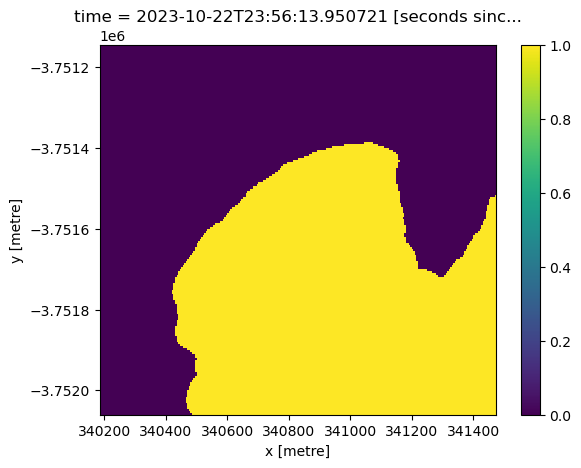

In [2]:
mndwi = (ds.nbart_green - ds.nbart_swir_2) / (ds.nbart_green + ds.nbart_swir_2)
water = (mndwi > 0)
water_mask = mask_cleanup(water, mask_filters=[("opening", 5)])
water_mask.plot()

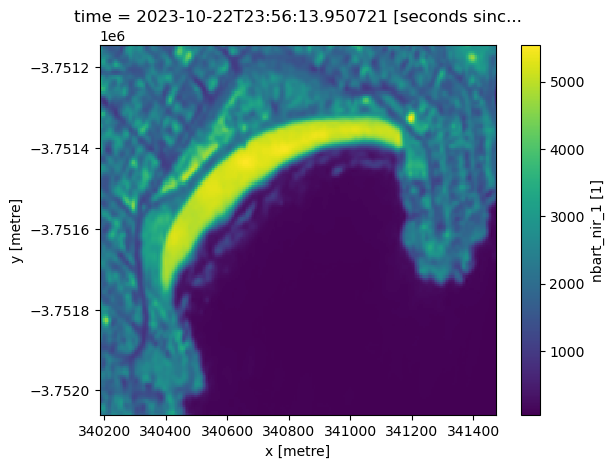

In [3]:
ds.nbart_nir_1.plot.imshow()

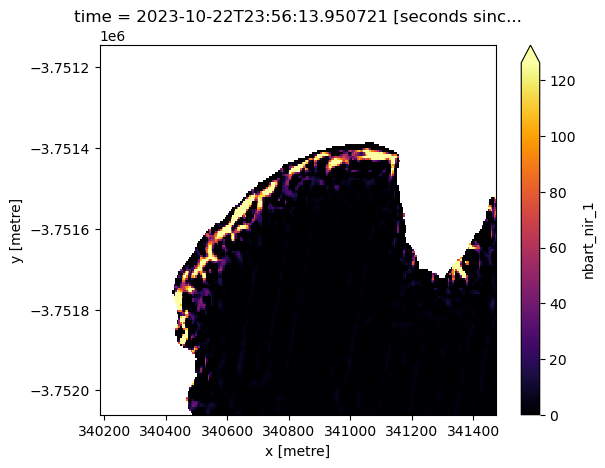

In [4]:
from skimage.morphology import black_tophat
from skimage.morphology import disk, square

test1 = black_tophat(ds.nbart_nir_1.compute(), footprint=disk(1))
test2 = black_tophat(ds.nbart_nir_1.compute(), footprint=disk(2))
test3 = black_tophat(ds.nbart_nir_1.compute(), footprint=disk(3))
test = ((test1 + test2 + test3) / 3).where(water_mask)
test.plot.imshow(robust=True, cmap="inferno")

<Axes: >

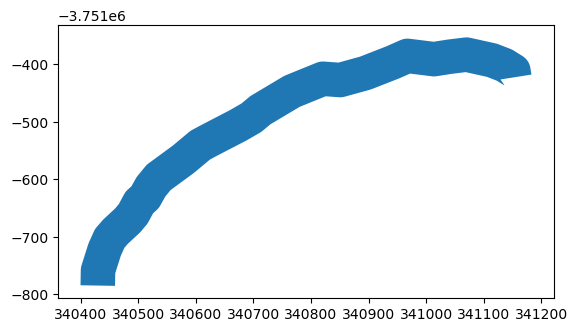

In [5]:
import geopandas as gpd
beach_gdf = gpd.read_file("/gdata1/data/beach_slopes/Australia_slopes_by_beach.geojson").set_index("beach_id")
beach = beach_gdf.loc[["aus0211"]].to_crs(ds.odc.crs)

buffered_beach = gpd.GeoDataFrame(geometry=beach.buffer(30, cap_style=2), crs=ds.odc.crs)
buffered_beach.plot()

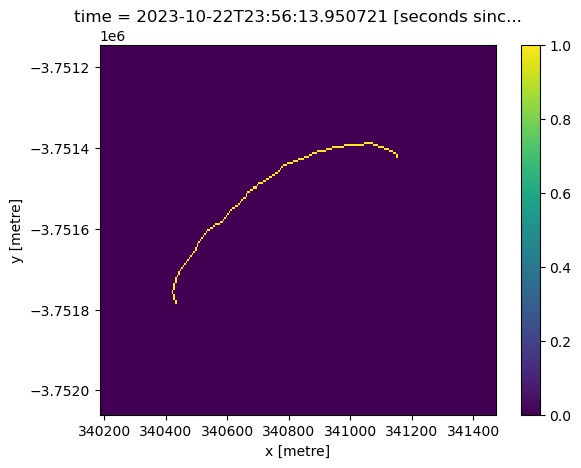

In [6]:
grown = mask_cleanup(water_mask, mask_filters=[("erosion", 1)])
waterline = (~grown & water_mask).astype(np.int16)
waterline = (waterline & xr_rasterize(buffered_beach, ds)).astype(np.int16)
waterline.plot()

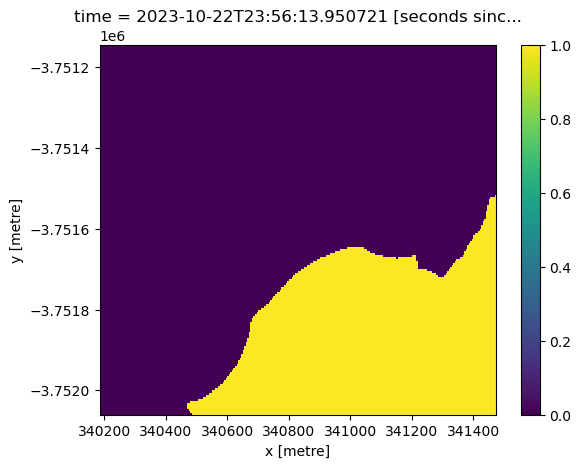

In [7]:
((mask_cleanup(waterline.astype(bool), mask_filters=[("dilation", 50)]) == 0) & water_mask).plot()

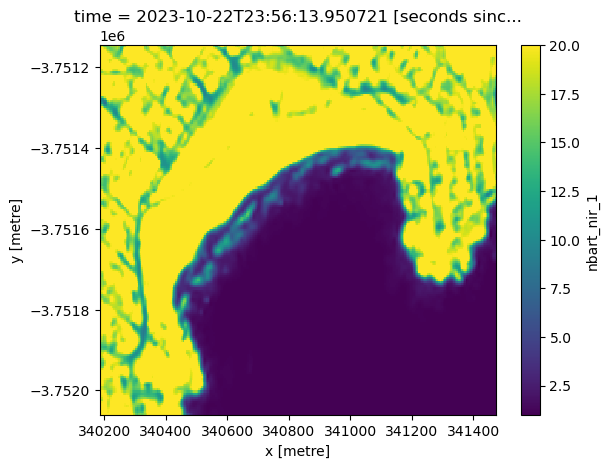

In [8]:
(ds.nbart_nir_1.clip(100, 2000) / 100).plot()

In [9]:
# cs = (ds.nbart_nir_1 / ds.nbart_nir_1.min())
cs = (ds.nbart_nir_1.clip(100, 2000) / 100)
lg = graph.MCP_Geometric(cs, sampling=(5, 5))

cs_null = odc.geo.xr.xr_zeros(ds.odc.geobox) + 1
lg_null = graph.MCP_Geometric(cs_null, sampling=(5, 5))

# Set starting points
start_array = waterline
starts = list(zip(*np.nonzero(start_array.values)))


ends_array = ((mask_cleanup(waterline.astype(bool), mask_filters=[("dilation", 50)]) == 0) & water_mask).astype(np.int16)
# ends_array = xr_rasterize(gpd.GeoDataFrame(geometry=beach.buffer(300).exterior, crs=ds.odc.crs), ds).where(water_mask, 0)
ends = list(zip(*np.nonzero(ends_array.values)))

# Calculate the least-cost distance from the start cell to all other cells
lcd, traceback = lg.find_costs(starts=starts, ends=ends)
lcd_null, traceback = lg_null.find_costs(starts=starts, ends=ends)

In [10]:
import rasterio  
  
Z = cs.where(water_mask, -9999).values
    
with rasterio.open(
    'rip_resistances.asc',
    'w',
    driver='AAIGrid',
    height=Z.shape[0],
    width=Z.shape[1],
    count=1,
    dtype=Z.dtype,
    nodata=-9999,
    crs=ds.odc.crs,
    transform=ds.odc.transform,
) as dst:
    dst.write(Z, 1)
    
    
Z = start_array.where(start_array > 0, -9999).values
# Z[Z == 1] = np.arange(1, len(Z[Z == 1]) + 1)
    
    
with rasterio.open(
    'rip_sources.asc',
    'w',
    driver='AAIGrid',
    height=Z.shape[0],
    width=Z.shape[1],
    count=1,
    dtype=Z.dtype,
    nodata=-9999,
    crs=ds.odc.crs,
    transform=ds.odc.transform,
) as dst:
    dst.write(Z, 1)
    
    
Z = ends_array.where(ends_array > 0, -9999).values

    
with rasterio.open(
    'rip_grounds.asc',
    'w',
    driver='AAIGrid',
    height=Z.shape[0],
    width=Z.shape[1],
    count=1,
    dtype=Z.dtype,
    nodata=-9999,
    crs=ds.odc.crs,
    transform=ds.odc.transform,
) as dst:
    dst.write(Z, 1)
    
    

In [11]:
import rioxarray

current = rioxarray.open_rasterio("rip_curmap.asc")
voltage = rioxarray.open_rasterio("rip_voltmap.asc")

In [12]:
mask = current != 0
current_masked = current.where(mask)
voltage_masked = voltage.where(mask)

In [17]:
(voltage_masked / 15).clip(0, 1)

<xarray.DataArray (band: 1, y: 183, x: 258)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 3.402e+05 3.402e+05 ... 3.415e+05 3.415e+05
  * y            (y) float64 -3.751e+06 -3.751e+06 ... -3.752e+06 -3.752e+06
    spatial_ref  int64 0

In [20]:
(current_masked * (voltage_masked / 20).clip(0, 1)).odc.write_cog("rip_output5.tif")

PosixPath('rip_output5.tif')

In [ ]:
pip install fuzzylogic

In [ ]:
current_masked.plot()

In [ ]:
current_masked.where(voltage_masked > 15).odc.write_cog("rip_output.tif")

In [ ]:
plt.imshow(np.where(water_mask, lcd / lcd_null, np.nan))

In [ ]:
path = np.zeros_like(cs.values)
for start in starts:

    indices, weight = graph.route_through_array(cs.values, start=start, end=(180, 150))
    indices = np.stack(indices, axis=-1)

    path[indices[0], indices[1]] = path[indices[0], indices[1]] + 1

In [ ]:
plt.imshow(path)

In [ ]:
np.where(water_mask, path, np.nan)

In [ ]:
plt.imshow(np.where(water_mask, path, np.nan), vmax=20)
# plt.imshow(lcd)
plt.scatter(140, 140)

In [ ]:
ds.nbart_nir_1.plot.imshow()

In [ ]:
test1 = black_tophat(lcd, footprint=disk(1))
test2 = black_tophat(lcd, footprint=disk(2))
test3 = black_tophat(lcd, footprint=disk(3))
test = np.where(water_mask, (test1 + test2 + test3) / 3, np.nan)
plt.imshow(test, cmap="inferno")

In [ ]:
odc.geo.xr.wrap_xr(test, gbox=ds.odc.geobox).odc.write_cog("rip_tophat.tif", overwrite=True)

In [ ]:
ds.nbart_nir_1.where(water_mask, 10000).odc.write_cog("rip_nir.tif", overwrite=True)


# test.odc.write_cog("rip_test.tif", overwrite=True)

In [ ]:
ds.nbart_nir_1.where(water_mask, 10000).plot()

In [ ]:
from pysheds.grid import Grid

# Instantiate grid from raster
grid = Grid.from_raster('/home/jovyan/Robbi/dea-notebooks/Testing/rip_nir.tif')
dem = grid.read_raster('/home/jovyan/Robbi/dea-notebooks/Testing/rip_nir.tif')

# Resolve flats and compute flow directions
inflated_dem  = dem
# inflated_dem = grid.resolve_flats(dem)

In [ ]:
fdir = grid.flowdir(inflated_dem, routing='mfd')

In [ ]:
grid.distance_to_ridge(fdir, routing='mfd')

In [ ]:
acc = grid.accumulation(fdir, routing='mfd')

In [ ]:
plt.imshow(acc, vmax=100)

In [ ]:
odc.geo.xr.wrap_xr(acc, gbox=ds.odc.geobox).odc.write_cog("rip_acc.tif", overwrite=True)

In [ ]:
# From the cost-surface create a 'landscape graph' object which can be
# analysed using least-cost modelling
lg = graph.MCP_Geometric(cs, sampling=(cell_size, cell_size))

# Convert input point to pixel-based indices
coords_start_crs = list(point.coords)[0]
coords_start = ~cs.geobox.transform * coords_start_crs

# Rearrange starting coordinates and convert to integers
starts = [[int(x) for x in coords_start[::-1]]]
    

ends = list(zip(*np.nonzero(end_array)))

# Calculate the least-cost distance from the start cell to all other cells
lcd, trace = lg.find_costs(starts=starts, 
                           ends=ends, 
                           find_all_ends=False)